## Code required to create Figure 4
Entire notebook takes: X seconds on Intel i7-10750 using > 4GB RAM

In [1]:
import glob
import re
import os
import datetime
import collections
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sns.set_context('paper')

# Functions to load CMIP6 data

In [2]:
def make_combined_df_from_data_paths(data_paths, date_format="\d{2}:\d{2}:\d{2}", data_name=None):
    df = pd.read_csv(data_paths[0])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[0])[-1].split("_")[2]
        wrote_data_name = True
    df.columns = ["time", data_name]
    # remove time from date
    df['time'] = df['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    for f in data_paths[1:]:
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2]
        else:
            current_data_name = data_name
        current.columns = ["time", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
        df = df.merge(current, how='outer', on='time')
    df = df.set_index('time')
    df = df.sort_index()
    return df


def make_combined_df_from_data_paths_for_bracegirdle(data_paths, data_name=None):
    df = pd.read_csv(data_paths[0])
    df = remove_unwanted_columns(df)
    wrote_data_name = False
    if not data_name:
        data_name = os.path.split(data_paths[0])[-1].split("_")[2]
        wrote_data_name = True
    df.columns = ["year", data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
    # remove time from date
    for f in data_paths[1:]:
        current = pd.read_csv(f, header=0)
        current = remove_unwanted_columns(current)
        if wrote_data_name:
            current_data_name = os.path.split(f)[-1].split("_")[2]
        else:
            current_data_name = data_name
        current.columns = ["year", current_data_name] # Note: makes the assumption that time and jet lat is this way around (check because would fail otherwise)
        # remove time from date
        df = df.merge(current, how='outer', on='year')
    df = df.set_index('year')
    df = df.sort_index()
    return df


def remove_unwanted_columns(data):
    for col in data.columns:
        if col in COLS_TO_REMOVE:
            data = data.drop(col, axis=1)
    return data

# Globals

In [3]:
METRIC_NAMES = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Polvani 2015", "Barnes & Simpson 2017",\
                        "Grise & Polvani 2017", "Bracegirdle et al. 2018", "Ceppi et al. 2018", "Kerr et al. 2020"]
METRIC_DATA_NAMES = ['Woollings2010_NorthPacific', 'BarnesPolvani2013_NorthPacific','BarnesPolvani2015_NorthPacific',\
                     'BarnesSimpson2017_NorthPacific','GrisePolvani2017_NorthPacific', 'Bracegirdle2018_NorthPacific',\
                     'Ceppi2018_NorthPacific', 'Kerr2020_NorthPacific']
METRIC_SHORTHAND = ["W10", "BP13", "BP15", "BS17", "GP17", "B18", "C18", "K20"]

In [4]:
METRIC_LABEL_RENAMER = dict(zip(METRIC_DATA_NAMES, METRIC_NAMES))
METRIC_SHORTHAND_LABEL_RENAMER = dict(zip(METRIC_NAMES, METRIC_SHORTHAND))

In [5]:
PVAL_SIG = 0.05

In [6]:
ALL_MONTHS = ["January", "February", "March", "April", "May", "June",\
              "July", "August", "September", "October", "November", "December"]
ALL_MONTHS_SHORT = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [7]:
MONTH_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS))
MONTH_SHORT_DICT = dict(zip(np.arange(1, 13), ALL_MONTHS_SHORT))

# Load CMIP6 SSP5-8.5 

In [9]:
CMIP6_2015to2100_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_2070to2100_NPAC runs/ua_day*"

In [10]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Polvani 2015", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Ceppi et al. 2018", "Kerr et al. 2020"]

COLS_TO_REMOVE = ["10_day_average", "plev"]

In [18]:
print("Num of North Pacific files:", len(glob.glob(CMIP6_2015to2100_dir + "North Pacific" + "*")))

Num of North Pacific files: 478


In [13]:
%%time
time_ranges = []
failed_data_paths = []
date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_2015to2100_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except Exception as e:
#         print(e)
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    time_ranges.append(str(first_time)+'to'+str(last_time))

CPU times: user 3.03 s, sys: 171 ms, total: 3.2 s
Wall time: 3.2 s


In [14]:
collections.Counter(time_ranges)

Counter({'2070-01-01to2099-12-31': 100,
         '2070-01-01to2099-12-30': 18,
         '2070-01-01to2099-12-22': 9,
         '2070-01-01to2099-12-25': 8,
         '2070-01-01to2070-12-31': 6,
         '2071-01-01to2099-12-31': 6,
         '2070-01-01to2099-12-21': 3,
         '2070-01-01to2070-12-27': 1,
         '2071-01-01to2099-12-30': 1})

In [15]:
%%time
all_df_npac_future_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_2015to2100_dir + metric + "*" + "North Pacific" + "*"))
        continue
    all_df_npac_future_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_2015to2100_dir + metric + "*" + "North Pacific" + "*"))


CPU times: user 3.56 s, sys: 210 ms, total: 3.77 s
Wall time: 3.78 s


In [16]:
all_df_npac_future_dataset['Woollings et al. 2010'].columns

Index(['CMCC-ESM2', 'HadGEM3-GC31-MM', 'NorESM2-LM', 'NESM3_x',
       'ACCESS-ESM1-5', 'NorESM2-MM', 'CanESM5', 'MRI-ESM2-0', 'CESM2-WACCM',
       'NESM3_y', 'MPI-ESM1-2-HR', 'ACCESS-CM2', 'TaiESM1', 'HadGEM3-GC31-LL',
       'MIROC6', 'BCC-CSM2-MR', 'CMCC-CM2-SR5', 'FGOALS-g3', 'AWI-CM-1-1-MR',
       'MPI-ESM1-2-LR', 'UKESM1-0-LL'],
      dtype='object')

In [17]:
all_df_npac_future_dataset['Barnes & Polvani 2015'].columns

Index(['IITM-ESM', 'ACCESS-CM2', 'AWI-CM-1-1-MR', 'TaiESM1', 'NorESM2-MM',
       'HadGEM3-GC31-LL', 'CMCC-CM2-SR5', 'BCC-CSM2-MR', 'MPI-ESM1-2-LR',
       'CMCC-ESM2', 'NESM3_x', 'CESM2-WACCM', 'UKESM1-0-LL', 'ACCESS-ESM1-5',
       'FGOALS-g3', 'MIROC6', 'HadGEM3-GC31-MM', 'MRI-ESM2-0', 'CanESM5',
       'NorESM2-LM', 'NESM3_y', 'MPI-ESM1-2-HR'],
      dtype='object')

#### cleaning data

In [18]:
%%time
START_YEAR = "2070"
END_YEAR = "2100"
FREQ = 'd'
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_future_dataset[metric].index = pd.date_range(start=START_YEAR, freq="y", periods=len(all_df_npac_future_dataset[metric]))
        all_df_npac_future_dataset[metric].index = all_df_npac_future_dataset[metric].index.rename('time')
    all_df_npac_future_dataset[metric].index = pd.to_datetime(all_df_npac_future_dataset[metric].index, errors='coerce')
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric][START_YEAR: END_YEAR]
    
    if 'UKESM1-0-LL' in all_df_npac_future_dataset[metric].columns and 'UKESM1-0-LL_y' in all_df_npac_future_dataset[metric].columns:
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].drop('UKESM1-0-LL', axis=1)
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].rename({'UKESM1-0-LL_y':'UKESM1-0-LL'}, axis=1)
        print('removed and renamed UKESM1-0-LL_y')
    if 'UKESM1-0-LL_y' in all_df_npac_future_dataset[metric].columns:
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].drop('UKESM1-0-LL_x', axis=1)
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].rename({'UKESM1-0-LL_y':'UKESM1-0-LL'}, axis=1)
        print('removed UKESM1-0-LL_y and renamed UKESM1-0-LL_x')
    if 'CESM2-WACCM_x' in all_df_npac_future_dataset[metric].columns:
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].drop('CESM2-WACCM_x', axis=1)
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].rename({'CESM2-WACCM_y':'CESM2-WACCM'}, axis=1)
        print('removed and renamed CESM2-WACCM')
    if 'NESM3_x' in all_df_npac_future_dataset[metric].columns:
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].drop('NESM3_x', axis=1)
        all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].drop('NESM3_y', axis=1)
        # all_df_npac_future_dataset[metric] = all_df_npac_future_dataset[metric].rename({'NESM3_x':'NESM3'}, axis=1)
        print('removed NESM3')
    else:
        print('removed already!')

removed NESM3
removed NESM3
removed NESM3
removed NESM3
removed NESM3
removed NESM3
removed NESM3
removed NESM3
CPU times: user 132 ms, sys: 20 ms, total: 152 ms
Wall time: 152 ms


In [19]:
all_df_npac_future_dataset['Woollings et al. 2010'].columns.nunique() == len(all_df_npac_future_dataset['Woollings et al. 2010'].columns)

True

<Axes: xlabel='time'>

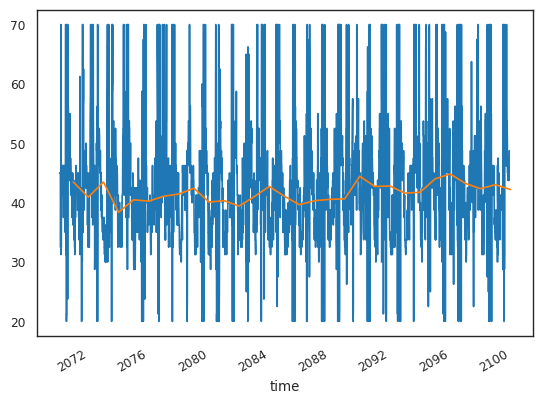

In [20]:
all_df_npac_future_dataset['Woollings et al. 2010']['HadGEM3-GC31-LL'].dropna().plot()
all_df_npac_future_dataset['Bracegirdle et al. 2018']['HadGEM3-GC31-LL'].dropna().plot()

# Load CMIP6 Historical

In [12]:
CMIP6_Historical_dir = "/home/thomaskeel/Documents/PhD/JASMIN experiments/CMIP6_Historical_NPAC runs/ua_day*"

In [13]:
metric_names = ["Woollings et al. 2010", "Barnes & Polvani 2013", "Barnes & Polvani 2015", \
                "Barnes & Simpson 2017", "Grise & Polvani 2017", "Bracegirdle et al. 2018", \
                "Ceppi et al. 2018", "Kerr et al. 2020"]
COLS_TO_REMOVE = ["10_day_average", "plev"]

region = "North Pacific"

In [14]:
print(region, len(glob.glob(CMIP6_Historical_dir + region + "*")))

North Pacific 814


In [24]:
%%time
# 40 seconds
time_ranges = []
failed_data_paths = []
date_format="\d{2}:\d{2}:\d{2}"
for file_path in glob.glob(CMIP6_Historical_dir):
    try:
        current = pd.read_csv(file_path, header=0)
    except Exception as e:
        print(e)
        print(file_path)
        continue
    for col in COLS_TO_REMOVE:
        try:
            current.drop(col, inplace=True, axis=1)
        except:
            pass
    try:
        current['time'] = current['time'].apply(lambda x: re.sub(date_format, "", x).strip())
    except Exception as e:
#         print(e)
        failed_data_paths.append(file_path)
        continue
    first_time = current['time'].min()
    last_time = current['time'].max()
    time_ranges.append(str(first_time)+'to'+str(last_time))

CPU times: user 13.4 s, sys: 462 ms, total: 13.8 s
Wall time: 13.8 s


In [25]:
collections.Counter(time_ranges)

Counter({'1950-01-01to2014-12-31': 228,
         '1950-01-01to2014-12-30': 24,
         '1950-01-01to2015-01-01': 18,
         '1950-01-01to2014-12-27': 18,
         '1950-01-01to2015-12-31': 6,
         '1950-01-02to2014-12-31': 6,
         '1950-01-01to2014-12-21': 4,
         '1950-01-02to2014-12-28': 1,
         '1950-01-01to2015-12-22': 1})

In [26]:
%%time
all_df_npac_hist_dataset = {}
for metric in metric_names:
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths_for_bracegirdle(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"))
        continue
    all_df_npac_hist_dataset[metric] = make_combined_df_from_data_paths(glob.glob(CMIP6_Historical_dir + metric + "*" + "North Pacific" + "*"))


CPU times: user 16.5 s, sys: 155 ms, total: 16.6 s
Wall time: 16.7 s


In [27]:
%%time
START_YEAR = "1984"
END_YEAR = "2014"
FREQ = 'd'
for metric in metric_names:
    print(metric)
    if metric == "Bracegirdle et al. 2018":
        all_df_npac_hist_dataset[metric].index = pd.date_range(start="1950", freq="y", periods=len(all_df_npac_hist_dataset[metric])) # NOTE: START YEAR HARD CODED
        all_df_npac_hist_dataset[metric].index = all_df_npac_hist_dataset[metric].index.rename('time')
    all_df_npac_hist_dataset[metric].index = pd.to_datetime(all_df_npac_hist_dataset[metric].index, errors='coerce')
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].groupby(pd.Grouper(freq=FREQ)).mean()
    all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric][START_YEAR: END_YEAR]
    if 'CESM2_x' in all_df_npac_hist_dataset[metric].columns:
        all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].drop('CESM2_x', axis=1)
        all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].rename({'CESM2_y':'CESM2'}, axis=1)
        print('removed and renamed CESM2')
    if 'NorCPM1' in all_df_npac_hist_dataset[metric].columns:
        all_df_npac_hist_dataset[metric] = all_df_npac_hist_dataset[metric].drop('NorCPM1', axis=1)
        print('removed and renamed NorCPM1 as lack of data')
    else:
        print('removed already!')

Woollings et al. 2010
removed already!
Barnes & Polvani 2013
removed already!
Barnes & Polvani 2015
removed already!
Barnes & Simpson 2017
removed already!
Grise & Polvani 2017
removed already!
Bracegirdle et al. 2018
removed already!
Ceppi et al. 2018
removed already!
Kerr et al. 2020
removed already!
CPU times: user 237 ms, sys: 76.1 ms, total: 313 ms
Wall time: 310 ms


## Load Reanalysis

In [28]:
START_YEAR = "1985"
END_YEAR = "2015"

In [29]:
era_npac_day_dict = {}

era_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
era_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
era_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_ERA5_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]


In [30]:
jra55_npac_day_dict = {}

jra55_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
jra55_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
jra55_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
jra55_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
jra55_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
jra55_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
jra55_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
jra55_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_JRA55_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]


In [31]:
merra2_npac_day_dict = {}

merra2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
merra2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
merra2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
merra2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
merra2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
merra2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
merra2_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
merra2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_MERRA2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]


In [32]:
ncepdoe2_npac_day_dict = {}

ncepdoe2_npac_day_dict['Woollings2010_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Woollings et al. 2010 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
ncepdoe2_npac_day_dict['BarnesPolvani2013_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2013 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
ncepdoe2_npac_day_dict['BarnesPolvani2015_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Polvani 2015 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
ncepdoe2_npac_day_dict['BarnesSimpson2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Barnes & Simpson 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
ncepdoe2_npac_day_dict['GrisePolvani2017_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Grise & Polvani 2017 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
ncepdoe2_npac_day_dict['Bracegirdle2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Bracegirdle et al. 2018 North Pacific.csv', index_col='year')
ncepdoe2_npac_day_dict['Ceppi2018_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Ceppi et al. 2018 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
ncepdoe2_npac_day_dict['Kerr2020_NorthPacific'] = pd.read_csv('/home/thomaskeel/Documents/PhD/JASMIN experiments/NPAC_only_NCEPDOE2_daily_outputs/Kerr et al. 2020 North Pacific.csv', index_col='time')[START_YEAR: END_YEAR]
